Notes:
* dask GroupBy tuning https://youtu.be/QY0zFsaO2j8

In [1]:
import dask.dataframe as dd
import pandas as pd

from distributed import Client, progress, wait

import dask

#dask.config.set(temporary_directory=os.getcwd())
dask.config.set(temporary_directory='/media/ian/data/mot_pandas2_polars_dask/data')


import os

In [2]:
os.chdir("../..")

client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 16,Total memory: 62.54 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41957,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 16
Started: Just now,Total memory: 62.54 GiB
Comm: tcp://127.0.0.1:34539,Total threads: 4
Dashboard: http://127.0.0.1:40641/status,Memory: 15.63 GiB
Nanny: tcp://127.0.0.1:40125,


In [3]:
def vehicle_grouper(df, groupby_sort=True, agg_shuffle=None):
    """Get summary data for each vehicle"""
    vehicle_df = df.groupby(
        "vehicle_id",
        sort=groupby_sort,  # True, False
    ).agg(
        {
            "make": "last",
            "model": "last",
            "fuel_type": "last",
            "cylinder_capacity": "last",
            "first_use_date": "last",
            "test_date": "max",
            "test_mileage": "max",
        },
        shuffle=agg_shuffle,  # None, 'disk', 'tasks', 'p2p'
    )
    return vehicle_df


def add_lifetime(df):
    """Get vehicle lifespan (vehicle may or may not still be in service)"""
    df["lifetime"] = (
        dd.to_timedelta((df["test_date"] - df["first_use_date"])).dt.days / 365
    )
    return df

In [ ]:
# 30m16s Giles, 18min Ian
vehicle_summary_ddf = (
    dd.read_parquet(
        path="test_result.parquet",
        # dtype_backend='pyarrow',
        # index='vehicle_id',
        # calculate_divisions=True,
        # columns=['make', 'model', 'fuel_type', 'cylinder_capacity', 'first_use_date', 'test_date', 'test_mileage'],
    )
    .query(
        'make in ["VOLVO", "VOLKSWAGEN", "ROVER"] & model in ["V50", "PASSAT", "200", "200 VI"]'
    )
    .dropna()
    .pipe(vehicle_grouper)
    .pipe(add_lifetime)
    .persist()
)
progress(vehicle_summary_ddf)

In [4]:
# 29m18s Giles, 34min to 854/854 aggregate-chunks and 120/123 agg-combines,then it seemlingly got stuck
vehicle_summary_ddf = (
    dd.read_parquet(path="test_result.parquet", dtype_backend="pyarrow")
    .query(
        'make in ["VOLVO", "VOLKSWAGEN", "ROVER"] & model in ["V50", "PASSAT", "200", "200 VI"]'
    )
    .dropna()
    .pipe(vehicle_grouper)
    .pipe(add_lifetime)
    .persist()
)
progress(vehicle_summary_ddf)

VBox()

Process Dask Worker process (from Nanny):
Process Dask Worker process (from Nanny):
2023-05-31 17:33:30,286 - distributed.nanny - ERROR - Worker process died unexpectedly
Process Dask Worker process (from Nanny):
2023-05-31 17:33:30,286 - distributed.nanny - ERROR - Worker process died unexpectedly
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/ian/miniconda3/envs/pydatalondon2023/lib/python3.11/asyncio/runners.py", line 118, in run
    return self._loop.run_until_complete(task)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/ian/miniconda3/envs/pydatalondon2023/lib/python3.11/asyncio/base_events.py", line 653, in run_until_complete
    return future.result()
           ^^^^^^^^^^^^^^^
Traceback (most recent call last):
  File "/home/ian/miniconda3/envs/pydatalondon2023/lib/python3.11/site-packages/distributed/nanny.py", line 955, in run
    await worker.finished()
  File "/home/ian/miniconda3/envs/pydatalondon2023/lib/python3.11/site-p

In [4]:
# 6m55s Giles
vehicle_summary_ddf = (
    dd.read_parquet(
        path="test_result_sorted.parquet",
        dtype_backend="pyarrow",
        index="vehicle_id",
        calculate_divisions=True,
    )
    .query(
        'make in ["VOLVO", "VOLKSWAGEN", "ROVER"] & model in ["V50", "PASSAT", "200", "200 VI"]'
    )
    .dropna()
    .pipe(vehicle_grouper, groupby_sort=True, agg_shuffle=None)
    .pipe(add_lifetime)
    .persist()
)
progress(vehicle_summary_ddf)

VBox()

2023-05-31 17:34:09,031 - distributed.nanny - ERROR - Worker process died unexpectedly
Process Dask Worker process (from Nanny):
Traceback (most recent call last):
  File "/home/ian/miniconda3/envs/pydatalondon2023/lib/python3.11/asyncio/runners.py", line 118, in run
    return self._loop.run_until_complete(task)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/ian/miniconda3/envs/pydatalondon2023/lib/python3.11/asyncio/base_events.py", line 653, in run_until_complete
    return future.result()
           ^^^^^^^^^^^^^^^
  File "/home/ian/miniconda3/envs/pydatalondon2023/lib/python3.11/site-packages/distributed/nanny.py", line 955, in run
    await worker.finished()
  File "/home/ian/miniconda3/envs/pydatalondon2023/lib/python3.11/site-packages/distributed/core.py", line 590, in finished
    await self._event_finished.wait()
  File "/home/ian/miniconda3/envs/pydatalondon2023/lib/python3.11/asyncio/locks.py", line 213, in wait
    await fut
asyncio.exceptions.CancelledError


In [ ]:
# 11m02s Giles
vehicle_summary_ddf = (
    dd.read_parquet(path="test_result.parquet", dtype_backend="pyarrow")
    .query(
        'make in ["VOLVO", "VOLKSWAGEN", "ROVER"] & model in ["V50", "PASSAT", "200", "200 VI"]'
    )
    .dropna()
    .pipe(vehicle_grouper, agg_shuffle="p2p")
    .pipe(add_lifetime)
    .persist()
)
progress(vehicle_summary_ddf)

In [4]:
# 2m19s Giles, Ian 3min
vehicle_summary_ddf = (
    dd.read_parquet(
        path="test_result_sorted.parquet",
        dtype_backend="pyarrow",
        index="vehicle_id",
        calculate_divisions=True,
    )
    .query(
        'make in ["VOLVO", "VOLKSWAGEN", "ROVER"] & model in ["V50", "PASSAT", "200", "200 VI"]'
    )
    .dropna()
    .pipe(vehicle_grouper, groupby_sort=True, agg_shuffle="p2p")
    .pipe(add_lifetime)
    .persist()
)
progress(vehicle_summary_ddf)

VBox()

In [ ]:
# 2m15s Giles
vehicle_summary_ddf = (
    dd.read_parquet(
        path="test_result_sorted.parquet",
        dtype_backend="pyarrow",
        index="vehicle_id",
        calculate_divisions=True,
        columns=[
            "make",
            "model",
            "fuel_type",
            "cylinder_capacity",
            "first_use_date",
            "test_date",
            "test_mileage",
        ],
        filters=[
            ("make", "in", ["VOLVO", "VOLKSWAGEN", "ROVER"]),
            ("model", "in", ["V50", "PASSAT", "200", "200 VI"]),
        ],
    )
    .dropna()
    .pipe(vehicle_grouper, groupby_sort=False, agg_shuffle="p2p")
    .pipe(add_lifetime)
    .persist()
)
progress(vehicle_summary_ddf)

In [ ]:
# Lifetime
vehicle_summary_ddf = (
    dd.read_parquet(
        path="test_result_sorted.parquet",
        dtype_backend="pyarrow",
        index="vehicle_id",
        calculate_divisions=True,
    )
    .query(
        'make in ["VOLVO", "VOLKSWAGEN", "ROVER"] & model in ["V50", "PASSAT", "200", "200 VI"]'
    )
    .dropna()
    .pipe(vehicle_grouper, groupby_sort=True, agg_shuffle="p2p")
    # .pipe(add_lifetime)
    .persist()
)
progress(vehicle_summary_ddf)

In [ ]:
vehicle_summary_ddf.head()

In [6]:
vehicle_summary_pdf = vehicle_summary_ddf.compute().sort_index()
vehicle_summary_pdf["test_date"] = pd.to_datetime(vehicle_summary_pdf["test_date"])
vehicle_summary_pdf["first_use_date"] = pd.to_datetime(
    vehicle_summary_pdf["first_use_date"]
)
vehicle_summary_pdf["surviving"] = vehicle_summary_pdf["test_date"] >= pd.Timestamp(
    "2022-01-01"
)
vehicle_summary_pdf["surviving_colour"] = vehicle_summary_pdf.surviving.map(
    {True: "blue", False: "red"}
)
vehicle_summary_pdf["fuel_colour"] = vehicle_summary_pdf.fuel_type.map(
    {"DI": "black", "PE": "blue", "HY": "green"}
)
vehicle_summary_pdf

,make,model,fuel_type,cylinder_capacity,first_use_date,test_date,test_mileage,lifetime,surviving,surviving_colour,fuel_colour
vehicle_id,,,,,,,,,,,
15936727,VOLKSWAGEN,PASSAT,DI,1968,2015-03-18,2022-03-24,116852,7.021918,True,blue,black
15937552,VOLKSWAGEN,PASSAT,DI,1896,2002-04-12,2022-08-26,189291,20.386301,True,blue,black
15937972,VOLKSWAGEN,PASSAT,DI,1968,2006-06-22,2014-07-25,165808,8.095890,False,red,black
15939999,VOLKSWAGEN,PASSAT,DI,1968,2013-06-27,2022-05-30,69146,8.928767,True,blue,black
15940976,VOLKSWAGEN,PASSAT,DI,1968,2006-06-23,2019-08-16,124084,13.156164,False,red,black
...,...,...,...,...,...,...,...,...,...,...,...
1483949071,VOLKSWAGEN,PASSAT,DI,1968,2016-12-30,2019-12-16,91078,2.961644,False,red,black
1483949288,VOLKSWAGEN,PASSAT,DI,1896,2001-12-31,2022-01-07,211678,20.032877,True,blue,black
1483959459,VOLKSWAGEN,PASSAT,DI,1598,2015-12-22,2022-02-25,52099,6.183562,True,blue,black


In [ ]:
vehicle_summary_pdf.groupby(["make", "surviving"])["model"].count()

In [ ]:
vehicle_summary_pdf.model.value_counts()

In [ ]:
vehicle_summary_pdf.fuel_type.value_counts()

In [ ]:
vehicle_summary_pdf.query('model == "200" & test_mileage == 205404')

In [ ]:
vehicle_summary_pdf.query('model == "V50" & test_mileage == 171443')

In [ ]:
vehicle_summary_pdf.query('model == "PASSAT" & test_mileage == 142191')

In [ ]:
vehicle_summary_pdf.query("vehicle_id in [1042513740, 1238787680, 1354367214]")

In [ ]:
v50s_df = (
    vehicle_summary_pdf.assign(year=vehicle_summary_pdf.first_use_date.dt.year).query(
        'model == "V50" & fuel_type == "DI" & cylinder_capacity == 1997'
    )
    # .query('1997 <= year <= 2001')
)

v50s_df.groupby("year").count()

In [7]:
passats_df = (
    vehicle_summary_pdf.assign(year=vehicle_summary_pdf.first_use_date.dt.year)
    .query('model == "PASSAT" & fuel_type == "PE" & cylinder_capacity == 1798')
    .query("1997 <= year <= 2001")
)

passats_df  # .groupby('year').count()

,make,model,fuel_type,cylinder_capacity,first_use_date,test_date,test_mileage,lifetime,surviving,surviving_colour,fuel_colour,year
vehicle_id,,,,,,,,,,,,
15962324,VOLKSWAGEN,PASSAT,PE,1798,1998-09-20,2011-07-13,144463,12.819178,False,red,blue,1998
16032818,VOLKSWAGEN,PASSAT,PE,1798,2000-06-09,2013-10-05,151824,13.331507,False,red,blue,2000
16460718,VOLKSWAGEN,PASSAT,PE,1798,1998-09-25,2010-10-06,236355,12.038356,False,red,blue,1998
16532790,VOLKSWAGEN,PASSAT,PE,1798,2000-05-11,2015-05-28,118722,15.054795,False,red,blue,2000
17015562,VOLKSWAGEN,PASSAT,PE,1798,2000-06-22,2013-06-24,123528,13.013699,False,red,blue,2000
...,...,...,...,...,...,...,...,...,...,...,...,...
1482303816,VOLKSWAGEN,PASSAT,PE,1798,1999-04-15,2013-08-24,108540,14.369863,False,red,blue,1999
1482555156,VOLKSWAGEN,PASSAT,PE,1798,2000-11-29,2013-07-23,139240,12.654795,False,red,blue,2000
1482922154,VOLKSWAGEN,PASSAT,PE,1798,1999-09-06,2012-10-12,121042,13.109589,False,red,blue,1999


In [ ]:
#rovers_df = vehicle_summary_pdf.query(
#    'model in ["200", "200 VI"] & cylinder_capacity == 1796'
#)#
#
#rovers_df

In [ ]:
#ax = rovers_df.dropna().plot.scatter(
#    figsize=(12, 6),
#    x="lifetime",
#    y="test_mileage",
#    marker=".",
#    alpha=0.5,
#    # s=0.5,
#    c="surviving_colour",
#)
#ax.set_xlim(5, 26)
#ax.set_ylim(0, 250000)

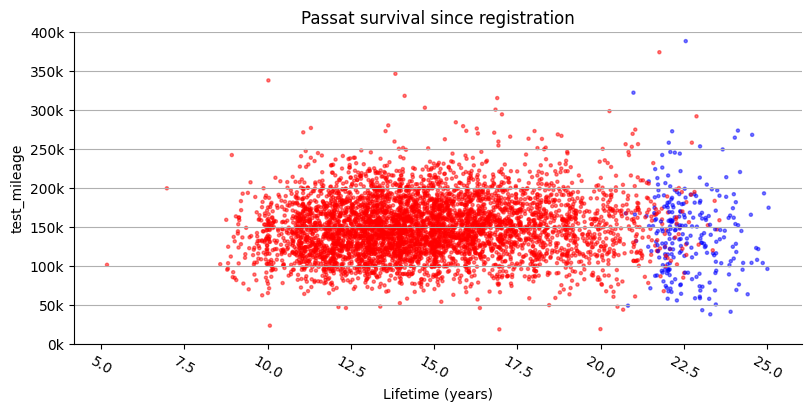

In [14]:
from simpler_mpl import set_common_mpl_styles, set_commas
import matplotlib.pyplot as plt

fig, ax = plt.subplots(constrained_layout=True)

passats_df.dropna().plot.scatter(
    figsize=(8, 4),
    x="lifetime",
    y="test_mileage",
    marker=".",
    alpha=0.5,
    # s=0.5,
    c="surviving_colour",
    ax=ax
)
#ax.set_xlim(5, 26)
ax.set_ylim(0, 400000)
#ax.plot(result["test_date"], result["passed"])  # , marker='o')
ax.yaxis.set_major_formatter(lambda x, pos: f"{int(x/1000):,}k")
plt.xticks(rotation=-30)
set_common_mpl_styles(
    ax, title="Passat survival since registration", ymin=0, xlabel="Lifetime (years)" #ylabel="Passing Tests per Week"
)


In [ ]:
ax = passats_df.dropna().plot.scatter(
    figsize=(12, 6),
    x="lifetime",
    y="test_mileage",
    marker=".",
    alpha=0.5,
    # s=0.5,
    c="surviving_colour",
)
ax.set_xlim(5, 26)
ax.set_ylim(0, 400000)

In [ ]:
passats_df.info()

In [ ]:
ax = (
    passats_df.resample(on="test_date", rule="1Y")
    .model.count()
    .loc[::-1]
    .cumsum()[::-1]
    .plot(marker=".")
)
ax.set_title("Passat Survival")

In [ ]:
ax = v50s_df.dropna().plot.scatter(
    figsize=(12, 6),
    x="lifetime",
    y="test_mileage",
    marker=".",
    alpha=0.5,
    # s=0.5,
    c="surviving_colour",
)
ax.set_xlim(5, 20)
ax.set_ylim(0, 300000)

In [ ]:
pd.concat([rovers_df, passats_df, v50s_df]).groupby(["make", "surviving"]).model.count()